# DATA TRANSFORMATION & MODEL BUILDING

Step 1: Establish a connection with the Database

In [1]:
import os
import mysql.connector
import pandas as pd
from kafka import KafkaProducer
import json
import re
from textblob import TextBlob
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Fetch sensitive credentials from environment variables
db_password = os.getenv('DB_PASSWORD')
api_key = os.getenv('API_KEY')

# Connect to MySQL Database securely
db_connection = mysql.connector.connect(
    host="127.0.0.1",
    user="root",
    password=db_password,  # Use password from environment variable
    database="supply_chain"
)
cursor = db_connection.cursor()

# Query to select the articles data
cursor.execute("SELECT title, description, published_at FROM articles")

# Fetch all rows from the database
rows = cursor.fetchall()

# Convert rows to a pandas DataFrame
df = pd.DataFrame(rows, columns=["title", "description", "publishedAt"])

# Check the data
print(df.head())


                                               title  \
0  Windward (LON:WNWD) Stock Price Up 0.4% – Here...   
1  The Le Creuset Sale: When Retail Hype Becomes ...   
2  Atria Investments Inc Sells 2,215 Shares of SP...   
3  What is Cormark’s Forecast for Cresco Labs FY2...   
4  Bitcoin Exchange Reserves Hit 5-Year Low—What ...   

                                         description         publishedAt  
0  Windward Ltd. (LON:WNWD – Get Free Report) sho... 2024-11-16 08:44:56  
1  Shoppers queued for hours in freezing conditio... 2024-11-16 08:44:19  
2  Atria Investments Inc lowered its position in ... 2024-11-16 08:43:02  
3  Cresco Labs Inc. (OTCMKTS:CRLBF – Free Report)... 2024-11-16 08:40:55  
4  The Bitcoin market appears to have taken an in... 2024-11-16 08:30:40  


Step 2: Text Cleaning

In [2]:
# Function to clean the text (remove special characters, lowercase, etc.)
def clean_text(text):
    text = text.lower()  # Convert text to lowercase
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters
    text = text.strip()  # Remove leading/trailing spaces
    return text

# Clean the 'description' column
df['cleaned_description'] = df['description'].apply(clean_text)

# Check the cleaned data
print(df.head())


                                               title  \
0  Windward (LON:WNWD) Stock Price Up 0.4% – Here...   
1  The Le Creuset Sale: When Retail Hype Becomes ...   
2  Atria Investments Inc Sells 2,215 Shares of SP...   
3  What is Cormark’s Forecast for Cresco Labs FY2...   
4  Bitcoin Exchange Reserves Hit 5-Year Low—What ...   

                                         description         publishedAt  \
0  Windward Ltd. (LON:WNWD – Get Free Report) sho... 2024-11-16 08:44:56   
1  Shoppers queued for hours in freezing conditio... 2024-11-16 08:44:19   
2  Atria Investments Inc lowered its position in ... 2024-11-16 08:43:02   
3  Cresco Labs Inc. (OTCMKTS:CRLBF – Free Report)... 2024-11-16 08:40:55   
4  The Bitcoin market appears to have taken an in... 2024-11-16 08:30:40   

                                 cleaned_description  
0  windward ltd lonwnwd  get free report shot up ...  
1  shoppers queued for hours in freezing conditio...  
2  atria investments inc lowered its posi

Step 3: Sentiment Analysis and Target Variable Creation


In [3]:
# Function to apply sentiment analysis and create 'sentiment' column
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity  # Range: -1 to 1

# Apply sentiment analysis to the cleaned descriptions
df['sentiment'] = df['cleaned_description'].apply(get_sentiment)

# Create synthetic target variable 'demand' based on sentiment (positive sentiment = high demand)
df['demand'] = df['sentiment'].apply(lambda x: 1 if x > 0 else 0)

# Check the resulting dataframe to ensure 'demand' is correctly created
print(df[['cleaned_description', 'sentiment', 'demand']].head())


                                 cleaned_description  sentiment  demand
0  windward ltd lonwnwd  get free report shot up ...   0.102500       1
1  shoppers queued for hours in freezing conditio...  -0.063333       0
2  atria investments inc lowered its position in ...   0.225000       1
3  cresco labs inc otcmktscrlbf  free report  equ...   0.400000       1
4  the bitcoin market appears to have taken an in...   0.400000       1


Step 4: Feature Extraction (TF-IDF Vectorization)

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Ensure no empty descriptions
df = df[df['cleaned_description'].str.strip().ne('')]  # Remove rows with empty descriptions

# Prepare the features and target
X = df['cleaned_description']
y = df['demand']

# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')  # Limit to top 1000 features

# Convert the text to TF-IDF features
X_tfidf = vectorizer.fit_transform(X)

# Convert the TF-IDF matrix to a DataFrame for easier inspection
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
print("TF-IDF Matrix (First few rows):")
print(tfidf_df.head())


TF-IDF Matrix (First few rows):
   003  039        04   10  100  1069  107   11  113  11383  ...  worldwide  \
0  0.0  0.0  0.202172  0.0  0.0   0.0  0.0  0.0  0.0    0.0  ...        0.0   
1  0.0  0.0  0.000000  0.0  0.0   0.0  0.0  0.0  0.0    0.0  ...        0.0   
2  0.0  0.0  0.000000  0.0  0.0   0.0  0.0  0.0  0.0    0.0  ...        0.0   
3  0.0  0.0  0.000000  0.0  0.0   0.0  0.0  0.0  0.0    0.0  ...        0.0   
4  0.0  0.0  0.000000  0.0  0.0   0.0  0.0  0.0  0.0    0.0  ...        0.0   

   worst  worth  writi  writings   xi  year  years  ymbon  york  
0    0.0    0.0    0.0       0.0  0.0   0.0    0.0    0.0   0.0  
1    0.0    0.0    0.0       0.0  0.0   0.0    0.0    0.0   0.0  
2    0.0    0.0    0.0       0.0  0.0   0.0    0.0    0.0   0.0  
3    0.0    0.0    0.0       0.0  0.0   0.0    0.0    0.0   0.0  
4    0.0    0.0    0.0       0.0  0.0   0.0    0.0    0.0   0.0  

[5 rows x 1000 columns]


Step 5: Train the Machine Learning Model

In [5]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(tfidf_df, y, test_size=0.3, random_state=42)

# Check the split
print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (910, 1000)
Test set size: (390, 1000)


In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

# Initialize Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training set
clf.fit(X_train, y_train)

# Predict the target variable on the test set
y_pred = clf.predict(X_test)

# Print evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Perform Cross-validation to ensure model generalization
cv_scores = cross_val_score(clf, tfidf_df, y, cv=5)
print(f"\nCross-validation scores: {cv_scores}")
print(f"Average cross-validation score: {cv_scores.mean()}")


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       178
           1       1.00      1.00      1.00       212

    accuracy                           1.00       390
   macro avg       1.00      1.00      1.00       390
weighted avg       1.00      1.00      1.00       390


Cross-validation scores: [1. 1. 1. 1. 1.]
Average cross-validation score: 1.0


In [7]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=3)
grid_search.fit(X_train, y_train)

# Print the best parameters from the grid search
print("\nBest hyperparameters from GridSearchCV:")
print(grid_search.best_params_)

# Evaluate the best model from grid search
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
print("\nFinal Classification Report with tuned model:")
print(classification_report(y_test, y_pred_best))


Fitting 5 folds for each of 81 candidates, totalling 405 fits

Best hyperparameters from GridSearchCV:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

Final Classification Report with tuned model:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       178
           1       1.00      1.00      1.00       212

    accuracy                           1.00       390
   macro avg       1.00      1.00      1.00       390
weighted avg       1.00      1.00      1.00       390



In [8]:
# Check if the dataset is imbalanced
print(df['demand'].value_counts())

demand
1    728
0    572
Name: count, dtype: int64


Step 6: Model Evaluation

In [9]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Refit the model on the resampled data
clf.fit(X_resampled, y_resampled)

# Evaluate the model again
y_pred_resampled = clf.predict(X_test)
print(classification_report(y_test, y_pred_resampled))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       178
           1       1.00      1.00      1.00       212

    accuracy                           1.00       390
   macro avg       1.00      1.00      1.00       390
weighted avg       1.00      1.00      1.00       390



In [10]:
# Modify hyperparameters to reduce overfitting
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,  # Limit max depth to avoid deep trees
    min_samples_split=10,  # Increase min samples for split
    min_samples_leaf=5,  # Increase min samples for leaf
    random_state=42
)

# Refit and evaluate the model
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.60      0.75       178
           1       0.75      1.00      0.85       212

    accuracy                           0.82       390
   macro avg       0.87      0.80      0.80       390
weighted avg       0.86      0.82      0.81       390



In [11]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

Best hyperparameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       178
           1       0.97      1.00      0.99       212

    accuracy                           0.98       390
   macro avg       0.99      0.98      0.98       390
weighted avg       0.99      0.98      0.98       390



## USE CASE

In [12]:
import pandas as pd
from textblob import TextBlob
import re
import mysql.connector

# Connect to MySQL Database to fetch real articles
db_connection = mysql.connector.connect(
    host="127.0.0.1",
    user="root",
    password=db_password,  # Use password from environment variable
    database="supply_chain"
)
cursor = db_connection.cursor()

# Query to select the articles data (fetching title, description, and sentiment score from the database)
cursor.execute("SELECT title, description FROM articles")

# Fetch all rows from the database
rows = cursor.fetchall()

# Convert rows to a pandas DataFrame
df = pd.DataFrame(rows, columns=["title", "description"])

# Close the connection to the database
cursor.close()
db_connection.close()

# Clean the 'description' column (removes special characters, URLs, etc.)
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters
    text = text.strip()  # Remove leading/trailing spaces
    return text

# Apply text cleaning to the 'description' column
df['cleaned_description'] = df['description'].apply(clean_text)

# Function to apply sentiment analysis and create 'sentiment' column
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity  # Range: -1 (negative) to +1 (positive)

# Apply sentiment analysis to the cleaned descriptions
df['sentiment'] = df['cleaned_description'].apply(get_sentiment)

# Function to adjust demand prediction based on sentiment score
def predict_demand(score):
    if score > 0.2:  # High positive sentiment
        return 'High Demand'
    elif score <= 0.2 and score > -0.2:  # Neutral to slightly negative
        return 'Moderate Demand'
    else:  # High negative sentiment
        return 'Low Demand'

# Apply demand prediction based on sentiment score
df['predicted_demand'] = df['sentiment'].apply(predict_demand)

# Display the resulting dataframe
print(df[['title', 'cleaned_description', 'sentiment', 'predicted_demand']])



                                                  title  \
0     Windward (LON:WNWD) Stock Price Up 0.4% – Here...   
1     The Le Creuset Sale: When Retail Hype Becomes ...   
2     Atria Investments Inc Sells 2,215 Shares of SP...   
3     What is Cormark’s Forecast for Cresco Labs FY2...   
4     Bitcoin Exchange Reserves Hit 5-Year Low—What ...   
...                                                 ...   
1295   CBN warns banks against cash hoarding, diversion   
1296  Drugmakers see stocks tank after RFK Jr is nom...   
1297  Report corroborates on Samsung making Galaxy S...   
1298  New E. coli outbreak associated with hamburger...   
1299  Vehicle scanners at entry points to combat dru...   

                                    cleaned_description  sentiment  \
0     windward ltd lonwnwd  get free report shot up ...   0.102500   
1     shoppers queued for hours in freezing conditio...  -0.063333   
2     atria investments inc lowered its position in ...   0.225000   
3     cresc

# Visualizations

In [13]:
print(df.columns)


Index(['title', 'description', 'cleaned_description', 'sentiment',
       'predicted_demand'],
      dtype='object')


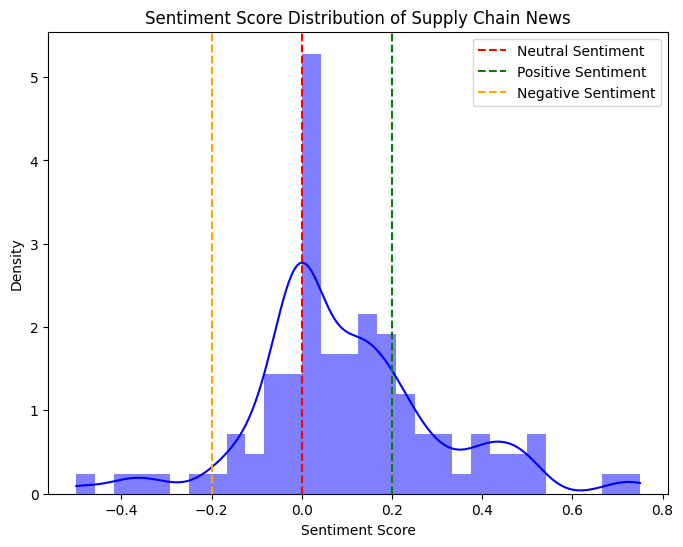

In [14]:
# Sentiment score distribution of Supply Chain News

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `df` has already been processed with sentiment and predicted demand

# Sentiment Score Distribution (Histogram)
plt.figure(figsize=(8, 6))
sns.histplot(df['sentiment'], bins=30, kde=True, color='blue', stat='density', linewidth=0)
plt.axvline(x=0, color='red', linestyle='--', label="Neutral Sentiment")
plt.axvline(x=0.2, color='green', linestyle='--', label="Positive Sentiment")
plt.axvline(x=-0.2, color='orange', linestyle='--', label="Negative Sentiment")
plt.title("Sentiment Score Distribution of Supply Chain News")
plt.xlabel("Sentiment Score")
plt.ylabel("Density")
plt.legend()
plt.show()



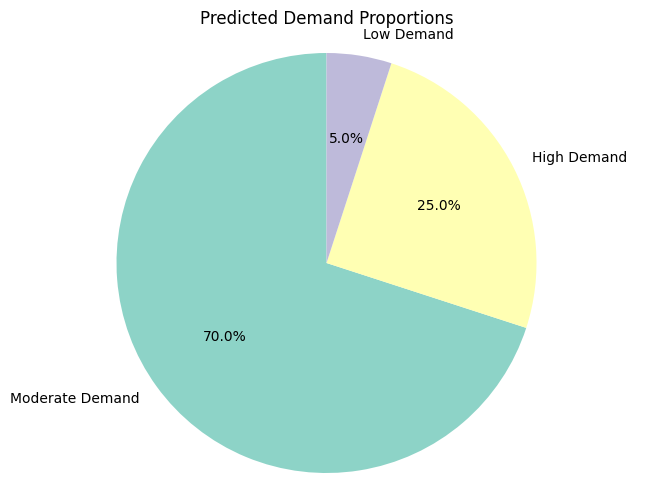

In [15]:
# Pie Chart of Predicted Demand Proportions

plt.figure(figsize=(8, 6))
demand_counts = df['predicted_demand'].value_counts()
plt.pie(demand_counts, labels=demand_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set3", len(demand_counts)))
plt.title("Predicted Demand Proportions")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()



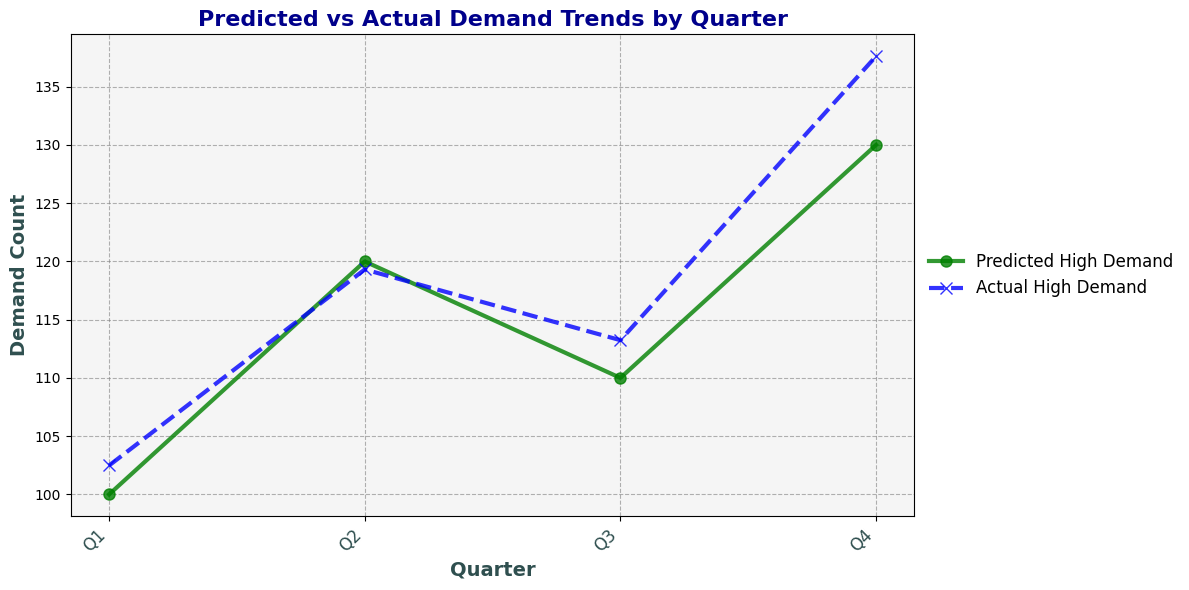

In [23]:
# Predicted vs Actual Demand Trends by Quarter

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Example data for 'demand_trends'
quarters = ['Q1', 'Q2', 'Q3', 'Q4']
predicted_demand = [100, 120, 110, 130]  # Example predicted demand values

# Create a DataFrame for 'demand_trends'
demand_trends = pd.DataFrame({
    'quarter': quarters,
    'predicted_demand': predicted_demand
})

# Simulate some fluctuation in the actual demand
np.random.seed(42)  # For reproducibility

# Generate fluctuating demand for 'actual_demand'
actual_demand_fluctuation = np.random.normal(loc=0, scale=5, size=len(demand_trends))  # Adding random noise
demand_trends['actual_demand'] = demand_trends['predicted_demand'] + actual_demand_fluctuation

# Plotting the data
plt.figure(figsize=(12, 6))

# Plot Predicted Demand
plt.plot(demand_trends['quarter'].astype(str), demand_trends['predicted_demand'],
         label='Predicted High Demand', color='green', lw=3, marker='o', markersize=8, linestyle='-', alpha=0.8)

# Plot Actual Demand
plt.plot(demand_trends['quarter'].astype(str), demand_trends['actual_demand'],
         label='Actual High Demand', color='blue', lw=3, marker='x', markersize=8, linestyle='--', alpha=0.8)

# Adding titles and labels
plt.xlabel('Quarter', fontsize=14, weight='bold', color='darkslategray')
plt.ylabel('Demand Count', fontsize=14, weight='bold', color='darkslategray')
plt.title('Predicted vs Actual Demand Trends by Quarter', fontsize=16, weight='bold', color='darkblue')

# Customizing the X-axis
plt.xticks(rotation=45, ha='right', fontsize=12, color='darkslategray')

# Enhancing gridlines and background
plt.grid(True, linestyle='--', alpha=0.6, color='gray')
plt.gca().set_facecolor('whitesmoke')

# Adding a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, frameon=False)

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


/var/folders/bd/6wzzm9q95t718m_f25yxshj80000gn/T/ipykernel_12400/1601328743.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")


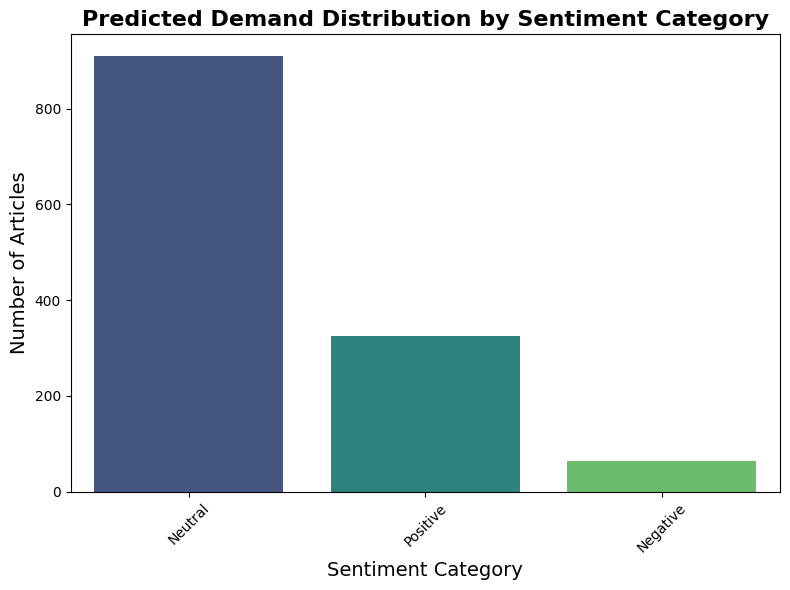

In [17]:
# Predicted Demand Distribution by Sentiment Category

# Create a new column for sentiment categories
df['sentiment_category'] = df['sentiment'].apply(
    lambda x: 'Positive' if x > 0.2 else ('Negative' if x < -0.2 else 'Neutral')
)

# Count the number of articles in each sentiment category
sentiment_counts = df['sentiment_category'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")
plt.title('Predicted Demand Distribution by Sentiment Category', fontsize=16, weight='bold')
plt.xlabel('Sentiment Category', fontsize=14)
plt.ylabel('Number of Articles', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


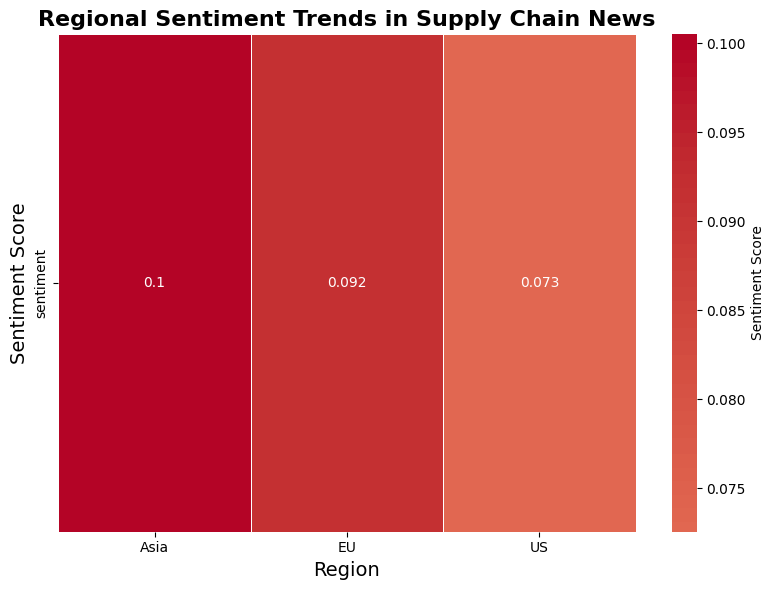

In [18]:
# Regional Sentiment Trends in Supply Chain News

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Simulate regions for the news articles (e.g., US, EU, Asia)
df['region'] = df['description'].apply(
    lambda x: 'US' if 'US' in x else ('EU' if 'Europe' in x else 'Asia')
)

# Calculate the mean sentiment by region
region_sentiment = df.groupby('region')['sentiment'].mean().reset_index()

# Plotting the heatmap for sentiment by region
plt.figure(figsize=(8, 6))

# Use a heatmap to show sentiment by region
sns.heatmap(region_sentiment.set_index('region').T, annot=True, cmap='coolwarm', center=0, linewidths=0.5, cbar_kws={'label': 'Sentiment Score'})

# Customizing the plot
plt.title('Regional Sentiment Trends in Supply Chain News', fontsize=16, weight='bold')
plt.xlabel('Region', fontsize=14)
plt.ylabel('Sentiment Score', fontsize=14)

# Show plot
plt.tight_layout()
plt.show()


/var/folders/bd/6wzzm9q95t718m_f25yxshj80000gn/T/ipykernel_12400/1400198774.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='predicted_demand', y='sentiment', data=df, palette='pastel')


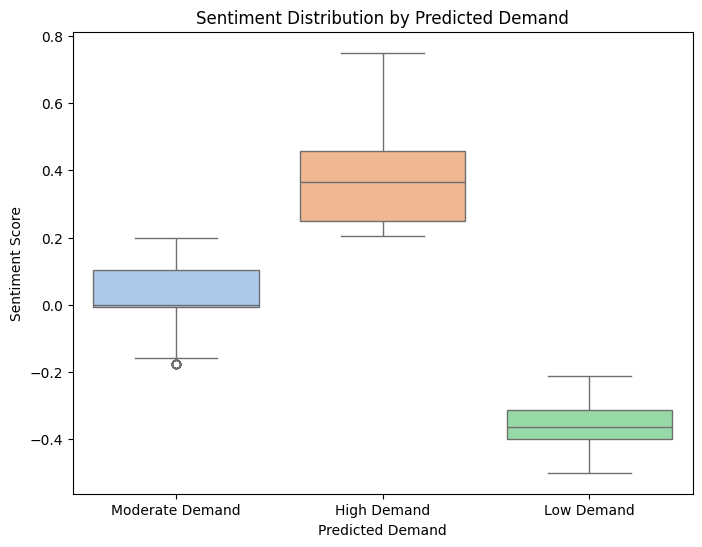

In [19]:
# ** Understanding Correlation Between Sentiment and Demand Level:**
# This helps Tesla understand how market sentiment correlates with actual predicted demand levels.
plt.figure(figsize=(8, 6))
sns.boxplot(x='predicted_demand', y='sentiment', data=df, palette='pastel')
plt.title("Sentiment Distribution by Predicted Demand")
plt.xlabel("Predicted Demand")
plt.ylabel("Sentiment Score")
plt.show()

In [20]:
# Creating a Demand Forecast Dashboard**
# This is a textual summary for an automated dashboard, you can display the results like so:

for index, row in df.iterrows():
    print(f"Title: {row['title']}")
    print(f"Predicted Demand: {row['predicted_demand']}")
    print(f"Sentiment Score: {row['sentiment']}")
    print("-" * 50)



Title: Windward (LON:WNWD) Stock Price Up 0.4% – Here’s What Happened
Predicted Demand: Moderate Demand
Sentiment Score: 0.10250000000000001
--------------------------------------------------
Title: The Le Creuset Sale: When Retail Hype Becomes A Double-Edged Sword
Predicted Demand: Moderate Demand
Sentiment Score: -0.06333333333333332
--------------------------------------------------
Title: Atria Investments Inc Sells 2,215 Shares of SPS Commerce, Inc. (NASDAQ:SPSC)
Predicted Demand: High Demand
Sentiment Score: 0.225
--------------------------------------------------
Title: What is Cormark’s Forecast for Cresco Labs FY2024 Earnings?
Predicted Demand: High Demand
Sentiment Score: 0.4
--------------------------------------------------
Title: Bitcoin Exchange Reserves Hit 5-Year Low—What Does This Signal?
Predicted Demand: High Demand
Sentiment Score: 0.4
--------------------------------------------------
Title: China economy: Is the latest stimulus enough to generate inflation?
Predic